In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Shuffle the data
train_data = shuffle(train_data)
test_data = shuffle(test_data)

X_train = train_data['text'].tolist()
y_train = train_data['label'].tolist()

X_test = test_data['text'].tolist()
y_test = test_data['label'].tolist()

# Perform undersampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(pd.DataFrame(X_train), y_train)

# Convert resampled data back to list
X_train_resampled = X_train_resampled[0].tolist()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the small embeddings model
model_name_small = 'jinaai/jina-embeddings-v2-small-en'
tokenizer_small = AutoTokenizer.from_pretrained(model_name_small)
model_small = AutoModel.from_pretrained(model_name_small).to(device)

def get_embeddings(text_list, tokenizer, model, device, batch_size=8):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    embeddings = np.vstack(embeddings)
    return embeddings

# Get embeddings for resampled train data and test data
X_train_embeddings = get_embeddings(X_train_resampled, tokenizer_small, model_small, device)
X_test_embeddings = get_embeddings(X_test, tokenizer_small, model_small, device)

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-small-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.2.intermediate.dense.weight', 'encoder.layer.2.output.LayerNorm.bias', 'encoder.layer.2.output.LayerNorm.weight', 'encoder.layer.2.output.dense.bias', 'encoder.layer.2.output.dense.weight', 'encoder.layer.3.intermediate.dense.bias', 'encoder.layer.3.intermediate.den

The best number of neighbors is: 1


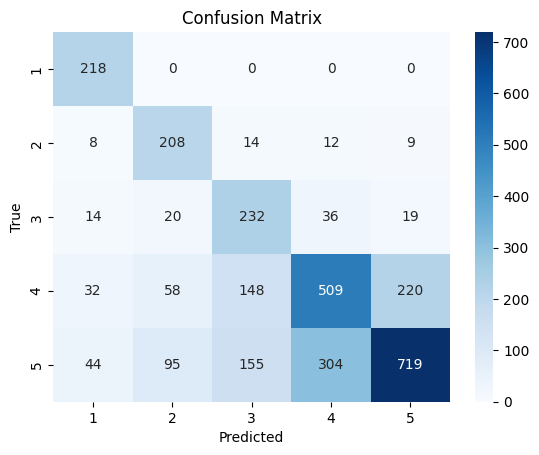

              precision    recall  f1-score   support

           1       0.69      1.00      0.82       218
           2       0.55      0.83      0.66       251
           3       0.42      0.72      0.53       321
           4       0.59      0.53      0.56       967
           5       0.74      0.55      0.63      1317

    accuracy                           0.61      3074
   macro avg       0.60      0.72      0.64      3074
weighted avg       0.64      0.61      0.61      3074



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Define the parameter grid
param_grid = {'n_neighbors': list(range(1, 21))}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV to find the best parameter
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_embeddings, y_train_resampled)

# Get the best parameter
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"The best number of neighbors is: {best_n_neighbors}")

# Train the KNN model with the best parameter
best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knn.fit(X_train_embeddings, y_train_resampled)

# Predict and evaluate
y_pred = best_knn.predict(X_test_embeddings)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# Save the model
with open('knn_model_base_emb.pkl', 'wb') as file:
    pickle.dump(knn, file)